In [13]:
import os
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib qt5

import mne
mne.__version__

'0.18.2'

In [14]:
data_dir = "data"

raw_fnames = {}
for d in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, d)):
        raw_fnames[d] = os.listdir(os.path.join(data_dir, d))
        break

dataset = []
for d in raw_fnames:
    subject = []
    for f in raw_fnames[d]:
        if f.endswith(".edf"):
            subject.append(mne.io.read_raw_edf(os.path.join(data_dir, d, f), preload=True))
    dataset.append(subject)

Extracting EDF parameters from C:\Users\Rock_\Desktop\Projects\Total_perspective_vortex\data\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from C:\Users\Rock_\Desktop\Projects\Total_perspective_vortex\data\S001\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from C:\Users\Rock_\Desktop\Projects\Total_perspective_vortex\data\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Rock_\Desktop\Projects\Total_perspective_vortex\data\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 se

In [15]:
print(dataset[0][0])
print(dataset[0][0].info)
print(dataset[0][0].info["ch_names"])

# events
print(dataset[0][2].annotations)

<RawEDF  |  S001R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.9 MB, data loaded>
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 80.0 Hz
    meas_date : tuple | 2009-08-12 16:15:00 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneT

In [16]:
# remove dots from channel's names
for j, subject in enumerate(dataset):
    for i, elem in enumerate(subject):
        dataset[j][i].rename_channels(lambda s: s.strip("."))

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 93 unique labels.


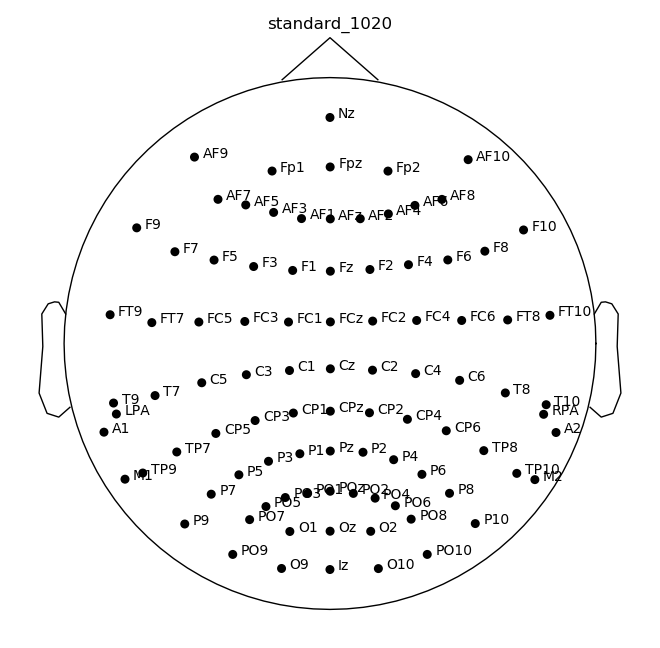

In [17]:
# plot montage
montage = mne.channels.read_montage("standard_1020")
montage.plot()

In [18]:
# set montage
for j, subject in enumerate(dataset):
    for i, elem in enumerate(subject):
        dataset[j][i].set_montage(montage)

In [19]:
# re-referencing
for j, subject in enumerate(dataset):
    for i, elem in enumerate(subject):
        dataset[j][i].set_eeg_reference("average")

Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.


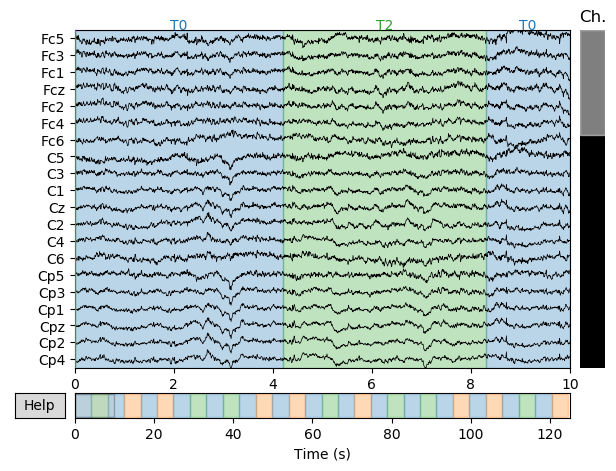

In [20]:
# plot data
mne.viz.plot_raw(dataset[0][2], scalings={"eeg": 75e-6})

In [21]:
# low freq filter
filtered_dataset = []
for j, subject in enumerate(dataset):
    filtered_subject = []
    for i, elem in enumerate(subject):
        elem_tmp = elem.copy()
        # set montage again since its is not copyed
        elem_tmp.set_montage(montage)
        elem_tmp.filter(1, None)
        filtered_subject.append(elem_tmp)
    filtered_dataset.append(filtered_subject)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameter

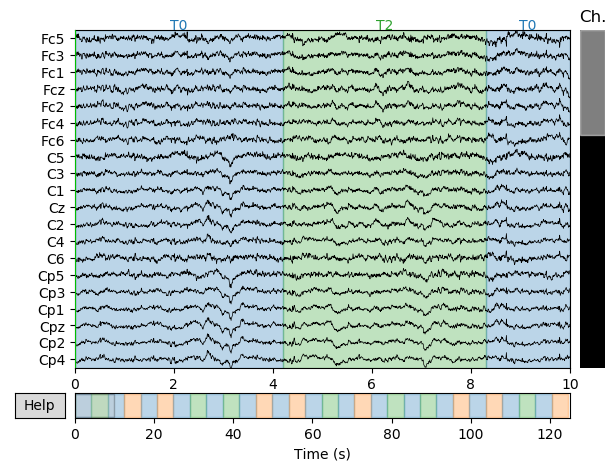

In [22]:
# plot data
mne.viz.plot_raw(filtered_dataset[0][2], scalings={"eeg": 75e-6})

In [23]:
# eye movements removal
ica = mne.preprocessing.ICA(method="extended-infomax", random_state=1)
for j, subject in enumerate(filtered_dataset):
    for i, elem in enumerate(subject):
        ica.fit(elem)
        ica.plot_components(inst=elem)
        break

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Computing Extended Infomax ICA


<ipython-input-23-e42fbf00a1ea>:2: DeprecationWarning: method='extended-infomax' is deprecated and will be removed in 0.19. If you want to use Extended Infomax, specify method='infomax' together with fit_params=dict(extended=True).
  ica = mne.preprocessing.ICA(method="extended-infomax", random_state=1)


Fitting ICA took 14.8s.
